# Clustering FakeNewsNet

___OBS:___ _The data examined in this notebook can be downloaded from [here](https://www.kaggle.com/datasets/mdepak/fakenewsnet?resource=download&select=PolitiFactUserFeature.mat)_

### Table of Contents
1. [Initial processing of the data set](#processing)
2. [Constructing a generic BuzzFeed featurizer](#featurizer)
3. [Analyzing the FakeNewsNet-BuzzFeed graph](#graph-analysis)

In [116]:
from tqdm import tqdm
tqdm.pandas()

import warnings
from typing import List
from pathlib import Path
from itertools import product
from collections import defaultdict, Counter

import math
import numpy as np
import pandas as pd

import networkx as nx
from node2vec import Node2Vec

import netwulf as nw
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, f1_score, precision_score, recall_score, confusion_matrix

pd.options.future.infer_string = True

%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
networkx  : 2.8.8
netwulf   : 0.1.5
pandas    : 2.1.1
matplotlib: 3.5.3
numpy     : 1.22.4
re        : 2.2.1
nltk      : 3.8.1



<a class="anchor" id="processing"></a>
## 1. Initial processing of the data set

Initially, the dataset will be loaded and processed before 1) $K$ train/test splits are created with the incentive to run cross-validation for getting the generalization error and 2) training and evaluating model performances. Through initial investigations we found that the provided PolitiFact data was corrupted in the sense that the text-content of fake- and real news were identical. For this reason, we restrict the analysis to the BuzzFeed dataset.

In [117]:
# Set dataset name and path to data folder
dataset     = 'BuzzFeed'
DATA_DIR    = Path("../data")

### Text-based dataset

At first, we load the news- and user indices and construct a mapping between users and the news that they shared.

In [118]:
# Load social content data - i.e. user and news "interactions" 
newsId              = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}News.txt', sep='\t', header=None)
userId              = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}User.txt', sep='\t', header=None)

# Create index mappings
idx2newsId          = {i+1: key for i, key in enumerate(newsId[0])}
idx2userId          = {i+1: key for i, key in enumerate(userId[0])}

# Add real user and news ids/names to dataframe
NewsUser            = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}NewsUser.txt', sep='\t', header=None).rename(columns={0: 'newsIndex', 1: 'userIndex', 2: 'n_shares'})
NewsUser['newsId']  = NewsUser['newsIndex'].map(idx2newsId) 
NewsUser['userId']  = NewsUser['userIndex'].map(idx2userId)

# Show resulting dataframe
print(NewsUser.shape)
NewsUser.head()

(22779, 5)


,newsIndex,userIndex,n_shares,newsId,userId
0,45,1,1,BuzzFeed_Real_45,98d2b98ce305174e2f6c10b8f8a1a9d5
1,127,2,1,BuzzFeed_Fake_36,a273d0fd07c18a884ce2aa425813eb06
2,115,3,1,BuzzFeed_Fake_24,ac091e92df9e854a07563ffb397925d4
3,180,3,1,BuzzFeed_Fake_89,ac091e92df9e854a07563ffb397925d4
4,140,4,1,BuzzFeed_Fake_49,d2ded2de054f2ceb43dff7f80fc46774


Next we collect the fake- and real news in a single dataframe along with the respective news IDs.

In [119]:
# Load content of news data
fake_news       = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}_fake_news_content.csv', engine="pyarrow")
real_news       = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}_real_news_content.csv', engine="pyarrow")
df              = pd.concat([real_news, fake_news]).reset_index(drop=True)

# Add news id to dataframe
df['news_id']   = newsId

# Save processed data
df.to_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}NewsContent.csv', index=False)

### Word clouds of real and fake articles

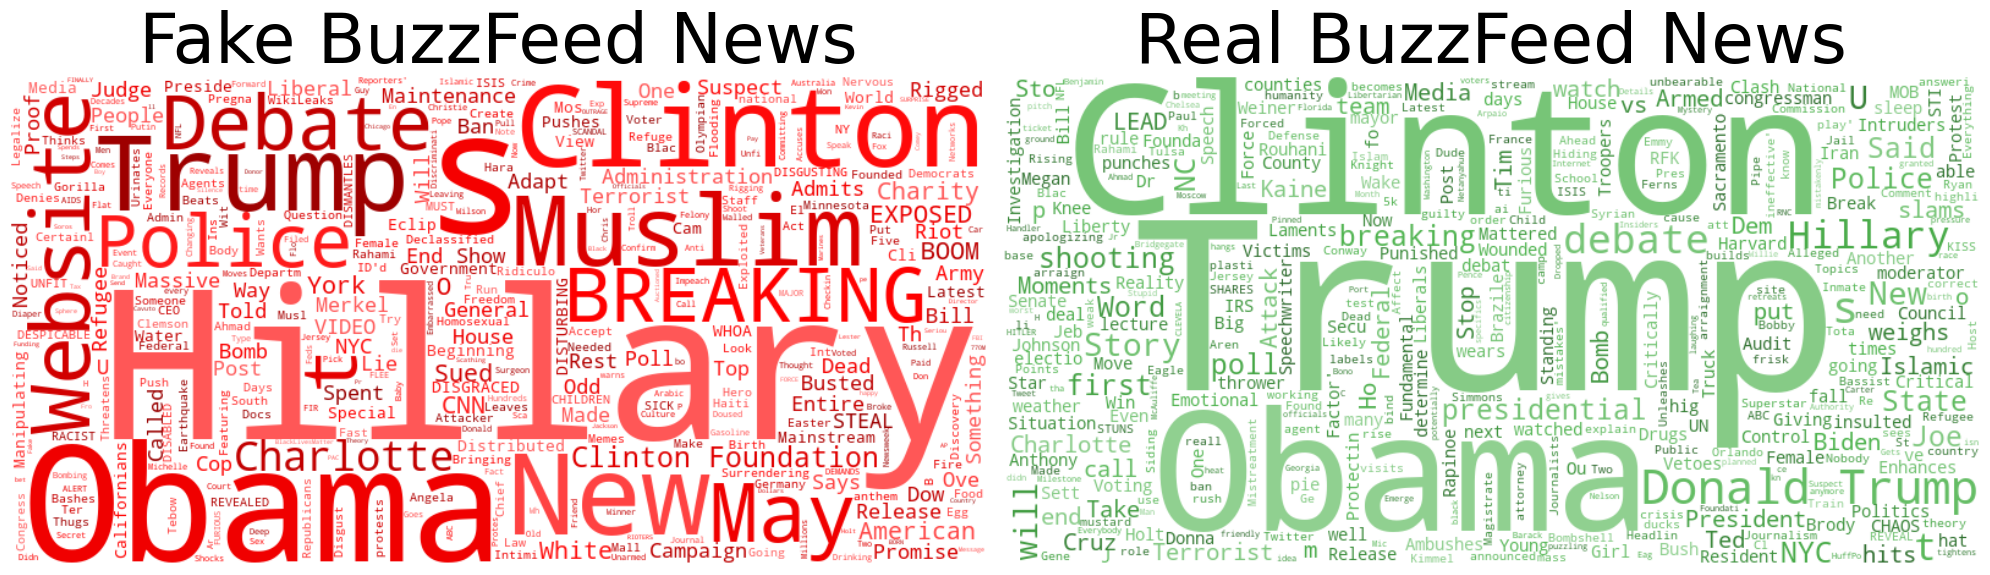

In [9]:
fake_news["full_text"] = fake_news["title"] + " " + fake_news["text"]
real_news["full_text"] = real_news["title"] + " " + real_news["text"]


def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 100%%, %d%%)" % np.random.randint(30, 70)  # Return the color of the text

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(120, 40%%, %d%%)" % np.random.randint(30, 70)  # Return the color of the text

# Create a word cloud for the fake news
wordcloud_fake = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           color_func=red_color_func,
                           width=800,  
                           height=400  
                          )
wordcloud_fake.generate(fake_news["full_text"].to_string())
wordcloud_fake.to_image()

# Create a word cloud for the real news
wordcloud_real = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           color_func=green_color_func,
                           width=800,  
                           height=400  
                          )
wordcloud_real.generate(real_news["full_text"].to_string())
wordcloud_real.to_image()

# Set up the figure and axes
fig, axarr = plt.subplots(1, 2, figsize=(20, 10))  # 1x2 grid of plots, adjust the figure size as needed

# Display the fake news word cloud on the left subplot
axarr[0].imshow(wordcloud_fake, interpolation='bilinear')
axarr[0].axis('off')
axarr[0].set_title("Fake BuzzFeed News", fontsize=50)

# Display the real news word cloud on the right subplot
axarr[1].imshow(wordcloud_real, interpolation='bilinear')  # Make sure you're showing wordcloud_real here
axarr[1].axis('off')
axarr[1].set_title("Real BuzzFeed News", fontsize=50)

# Adjust the spacing between the plots if necessary
plt.tight_layout()

plt.savefig("../reports/figures/BuzzFeedwordcloud.png", bbox_inches='tight')

plt.show()
del df, fake_news, real_news

### Constructing the FakeNewsNet-graph

We aim at representing the relation between news articles. As such, the final goal is to try to cluster news articles and evaluate these clusters compared to the ground truth _news/fake news_ labeling. For doing so, we construct a undirected graph with news articles as nodes and edges being defined by news article having at least two Twitter users that shares the article in common. Thus, the graph is constructed in the following steps:
1) Remove all singleton articles, i.e. find and remove all users that only shared one article
2) For all remaining users, find all tuple combinations of articles from the users sharing history (without self-loops)
3) Add weight to the edges by considering the amount of users that shared both the target and source node.
4) Build the undirected graph using `networkx`

In [120]:
# Find and remove all users that only shared one article
activeUsers         = np.sort(NewsUser['userIndex'].unique())[NewsUser.groupby('userIndex').size() > 1]
activeUsers_idxs    = NewsUser['userIndex'].apply(lambda x: x in activeUsers)
NewsUser_rev        = NewsUser[activeUsers_idxs]

In [121]:
# Inspiration from ChatGPT
def get_tuple_combinations(list1, list2):
    combinations = [(item1, item2) for item1, item2 in product(list1, list2) if item1 != item2 and item1 < item2]
    return combinations

# Prepare dictionary for storing edge information
connections = {'weights': defaultdict(int), 'userIds': defaultdict(list)}

# Consider news articles shared by each user
for user in tqdm(activeUsers, desc='Retrieving article links...'):
    # Extract information from the specific user
    user_content    = NewsUser_rev.query(f'userIndex == {user}')
    # Get all tuple-combination of shared articles
    connected_posts = get_tuple_combinations(user_content['newsIndex'], user_content['newsIndex'])
    
    # Add weight and userId to edge information
    for link in connected_posts:
        connections['weights'][link] += 1
        connections['userIds'][link].append(user)

Retrieving article links...: 100%|██████████| 3002/3002 [00:08<00:00, 358.53it/s]


Now, we can construct the weighted edgelist and save it.

In [122]:
# Construct weighted edgelist from the stored information
node1, node2                = list(zip(*connections['weights'].keys()))
weighted_edgelist           = pd.DataFrame([node1, node2, connections['weights'].values()], index=['source', 'target', 'weight']).T
weighted_edgelist['source'] = weighted_edgelist['source'].map(idx2newsId)
weighted_edgelist['target'] = weighted_edgelist['target'].map(idx2newsId)

# Store training graph and full graph
weighted_edgelist.to_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}_full_graph_weighted_edgelist.csv', index=False)
del weighted_edgelist

<a class="anchor" id="featurizer"></a>
## 2. Constructing a generic BuzzFeed featurizer

Next, we seek to construct a `BuzzFeedFeaturizer` object that contains functionalities for loading case-specific features (i.e. text- or graph variations) for each fold. This class along with auxiliary transformation functions are presented below.

In [124]:
# Download the stopwords dataset
nltk.download('stopwords', quiet=True)

def tokenize(text, stemmer, stop_words):
    """Tokenize text, stem, and remove stop words."""
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [stemmer.stem(token) for token in tokens if token not in stop_words]

def compute_tfidf_train(df, column_name):
    stemmer     = PorterStemmer()
    stop_words  = set(stopwords.words('english'))

    # Tokenize, stem and compute term frequency for each document
    df['tf'] = df[column_name].progress_apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Create a list of all unique words in the corpus
    all_unique_words = list(set(word for tf in df['tf'] for word in tf.keys()))

    # Compute the number of documents in which each word appears
    word_document_count = Counter(word for tf in df['tf'] for word in tf.keys())

    # Compute the total number of documents
    total_documents = len(df)

    # Compute inverse document frequency for each word
    idf = {word: math.log(total_documents / count) for word, count in word_document_count.items()}

    # Compute TF-IDF for each word in each document and ensure that all words in the corpus are represented
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * idf[word] for word in all_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf'], all_unique_words, idf

# We create a separate function for the test data because we need to use the IDF from the training data
def compute_tfidf_test(df, column_name, train_unique_words, train_idf):
    stemmer     = PorterStemmer()
    stop_words  = set(stopwords.words('english'))

    df['tf']    = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Compute TF-IDF for each word in each document using the vocabulary and IDF from training data
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * train_idf[word] for word in train_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)
    return df['tfidf']

def tf_idf(Xtrain, Xtest):
    Xtrain, all_unique_words, idf = compute_tfidf_train(Xtrain, 'full_text')   
    Xtest = compute_tfidf_test(Xtest, 'full_text', all_unique_words, idf) 

    # Convert the dictionaries in the "tfidf" column into a matrix
    dict_vectorizer = DictVectorizer(sparse=False)
    Xtrain          = dict_vectorizer.fit_transform(Xtrain)
    Xtest           = dict_vectorizer.transform(Xtest)

    # Normalize the TF-IDF vectors along the second axis (each article) so that all vectors have unit norm.
    Xtrain  = normalize(Xtrain, axis=1)
    Xtest   = normalize(Xtest, axis=1)
    return Xtrain, Xtest

def spectral_clustering(A, train_idxs, test_idxs, K_clusters, mode='text'):
    """ 
    Implementation following this paper, where arguments related to taking the maximum eigenvalues are used: 
    https://proceedings.neurips.cc/paper_files/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf
    """
    if mode == 'graph':
        nodes   = A.nodes()
        train_idxs, test_idxs = [i for i, node in enumerate(nodes) if node in train_idxs], [i for i, node in enumerate(nodes) if node in test_idxs]
        A       = np.array(nx.adjacency_matrix(A).todense())

    np.fill_diagonal(A, 0)
    
    # Compute degree matrix and degree power matrix
    degree_matrix           = np.diag(A.sum(axis=0).flatten())
    degree_power_matrix     = np.diag(np.power(np.diagonal(degree_matrix), -0.5))

    # L = D^-0.5 * A * D^-0.5
    laplacian               = degree_power_matrix.dot(A).dot(degree_power_matrix)
    assert np.allclose(np.tril(laplacian), np.triu(laplacian).T), 'Laplacian is not symmetric which is required for using np.linalg.eigh!'

    # Compute ordered eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eigh(laplacian)
    assert np.allclose(eigenvals, np.array(sorted(eigenvals))), 'Eigenvalues are not ordered correctly!'

    # Get largest eigenvals
    k_largest   = np.argpartition(eigenvals, -K_clusters)[-K_clusters:]

    # Restrict spectral embeddings to K clusters and normalize wrt. training set features # TODO: check whether this splittingis allowed !
    Xtrain      = eigenvecs[train_idxs, :][:, k_largest]
    Xtest       = eigenvecs[test_idxs, :][:, k_largest]
    Xtrain      = Xtrain[:, :K_clusters] / np.linalg.norm(Xtrain, axis=1)[:, None] 
    Xtest       = Xtest[:, :K_clusters] / np.linalg.norm(Xtest, axis=1)[:, None]

    # Split into train and test features
    if mode == 'text':
        return Xtrain, Xtest 
    else:
        ytrain  = np.array(['Real' in node for node in np.array(nodes)[train_idxs]]).astype(int).ravel()
        ytest   = np.array(['Real' in node for node in np.array(nodes)[test_idxs]]).astype(int).ravel()
        return Xtrain, ytrain, Xtest, ytest
    
# Maybe
def fastText(X):
    # TODO: implement fastText here...
    # TODO: make sure the format of the output is similar to that of transform_node2vec
    return X

def transform_node2vec(G, train_idxs, test_idxs, dimensions: int = 32, walk_length: int = 10, num_walks: int = 100, window: int = 10, min_count: int = 1):   
    ### READ MORE ABOUT NODE2VEC HERE: https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef ###
    
    np.random.seed(0)
    
    # Generate walks
    node2vec    = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, quiet=True)
    model       = node2vec.fit(window=window, min_count=min_count)

    # Get vector representations of splits
    train2vec       = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in train_idxs}
    test2vec        = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in test_idxs}

    # Modify training split
    Xtrain          = np.array(list(train2vec.values()))
    ytrain          = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in train_idxs]) 
    ytrain          = (ytrain == 'real').astype(int)

    # Modify test split
    Xtest           = np.array(list(test2vec.values()))
    ytest           = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in test_idxs])
    ytest           = (ytest == 'real').astype(int)
    return Xtrain, ytrain, Xtest, ytest


class BuzzFeedFeaturizer:

    def __init__(self, datapath: str, K: int = 10, graph_size_pct: int = 100, seed=0):
        
        # Define inputs
        self.datapath       = datapath
        self.K              = K
        # Load datasets
        self.text           = self.load_text()
        self.full_graph     = self.load_graph(graph_size_pct)
        self.labels         = pd.DataFrame(['Real' if 'real' in id_.lower() else 'Fake' for id_ in self.text['news_id']], index=self.text['news_id'])
        # Get dataset train/test splits for all folds
        self.split_indices  = self.get_split_indices(seed=seed)

    def get_split_indices(self, seed):
        np.random.seed(seed)

        # Permute all labels
        permuted_ids        = np.random.permutation(self.text['news_id'].unique())
        n_per_fold          = int(len(permuted_ids) / self.K)

        # Run splitting algorithm
        splits = {}
        for fold_ in range(self.K):
            test_ids        = permuted_ids[n_per_fold * fold_ : n_per_fold * (fold_ + 1)]
            train_ids       = np.setdiff1d(permuted_ids, test_ids)
            splits[fold_]   = {'test': test_ids, 'train': train_ids}
        return splits

    def load_text(self):
        # Load preprocessed text dataframe
        df                  = pd.read_csv(self.datapath / 'BuzzFeedNewsContent.csv')
        df["full_text"]     = df["title"] + " " + df["text"]
        return df

    def load_graph(self, graph_size_pct: int = None):
        # Load partial edgelist of network
        if graph_size_pct:
            self.weighted_edgelist = pd.read_csv(self.datapath / f'BuzzFeed_graph_{str(graph_size_pct)}.csv')
        # Load edgelist of full network
        else:
            self.weighted_edgelist = pd.read_csv(self.datapath / 'BuzzFeed_full_graph_weighted_edgelist.csv')
        # Create networkx graph
        return nx.from_pandas_edgelist(self.weighted_edgelist, source='source', target='target', edge_attr='weight', create_using=nx.Graph)

    def get_feature_split(self, feature_mode: str, fold: int, seed: int = 42, **kwargs):
        np.random.seed(seed)
        feature_info = {}

        # Get train and test ids
        train_idxs, test_idxs   = self.split_indices[fold]['train'], self.split_indices[fold]['test']
        
        ### TEXT REPRESENTATIONS ###
        if feature_mode in ['tf-idf', 'tf-idf_pca', 'spectral_text', 'fasttext']: # etc....
            Xtrain, Xtest           = self.text.query('news_id in @train_idxs').reset_index(drop=True), self.text.query('news_id in @test_idxs').reset_index(drop=True)
            ytrain                  = (self.labels.query('news_id in @train_idxs').reset_index(drop=True) == 'Real').astype(int).values.ravel()
            ytest                   = (self.labels.query('news_id in @test_idxs').reset_index(drop=True) == 'Real').astype(int).values.ravel()

            # Get TF-IDF representations
            if feature_mode != 'fasttext':
                Xtrain, Xtest       = tf_idf(Xtrain, Xtest)
                
                if feature_mode == 'tf-idf_pca':
                    pca = PCA(n_components=50)
                    pca.fit(Xtrain)
                    Xtrain = pca.transform(Xtrain)
                    Xtest = pca.transform(Xtest)

                # Get spectral clustering representation
                if feature_mode == 'spectral_text':

                    # Compute cosine document similarity as rows of "adjacency" are normalized
                    A = np.concatenate([Xtrain, Xtest])
                    cosine_doc_similarity   = A @ A.T

                    # Get feature splits
                    Xtrain, Xtest = spectral_clustering(cosine_doc_similarity, np.arange(Xtrain.__len__()), len(Xtrain) + np.arange(Xtest.__len__()), K_clusters=kwargs['K_clusters'])

            else:
                raise NotImplementedError('FastText not implemented!')

        ### GRAPH REPRESENTATIONS ###
        elif feature_mode in ['node2vec', 'spectral_graph']:
            if feature_mode == 'node2vec':
                Xtrain, ytrain, Xtest, ytest = transform_node2vec(self.full_graph, train_idxs, test_idxs)
                
            elif feature_mode == 'spectral_graph':
                Xtrain, ytrain, Xtest, ytest = spectral_clustering(self.full_graph, train_idxs, test_idxs, K_clusters=kwargs['K_clusters'], mode='graph')
                
        return Xtrain, ytrain, Xtest, ytest, feature_info

<a class="anchor" id="graph-analysis"></a>
## 3. Analyzing the FakeNewsNet-BuzzFeed graph

Before further exploring the featurizer, we verify that elements such as the full graph are stored in the object and run an initial analysis of the full graph.

Is the graph fully connected: True

Number of nodes: 	182
Number of edges: 	4772
Network diameter: 	4
Average shortest path: 	1.7663
Density: 		0.2897


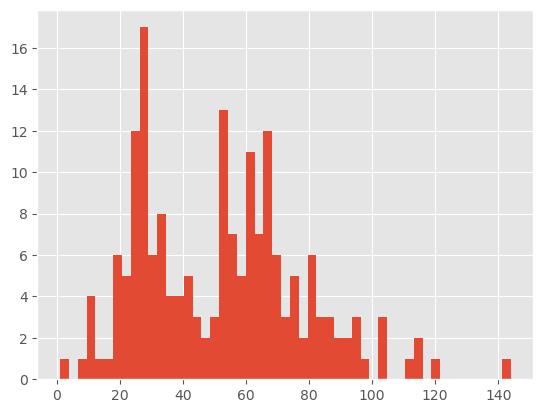

In [125]:
featurizer  = BuzzFeedFeaturizer(datapath=DATA_DIR / f'processed/FakeNewsNet', K=10)
G           = featurizer.full_graph

# Verify connectivity
print(f"Is the graph fully connected: {nx.is_connected(G)}\n")

# Network statistics
print(f"Number of nodes: \t{G.nodes().__len__()}")
print(f"Number of edges: \t{G.edges().__len__()}")
print(f"Network diameter: \t{nx.diameter(G)}")
print(f"Average shortest path: \t{nx.average_shortest_path_length(G):.4f}")
print(f"Density: \t\t{nx.density(G):.4f}")

# Degree distribution
plt.hist(dict(G.degree()).values(), bins=51)
plt.show()

As is seen, the network is quite dense in terms of links between nodes which can be seen from the degree distribution suggesting that most nodes have between 20-100 connections. This would immediately raise concerns regarding the task; namely that of predicting fake- or real news, since this could indicate that most nodes are connected to so many other nodes that there would be no clear distinction between the classes. However, visualizing the network using `netwulf` reveals a different finding, namely, that there is a somewhat apparent ground truth grouping of fake and real news with two minor intermediate groups with articles of limited degrees (size of nodes are degree). 

100%|██████████| 2/2 [00:00<00:00, 2712.13it/s]


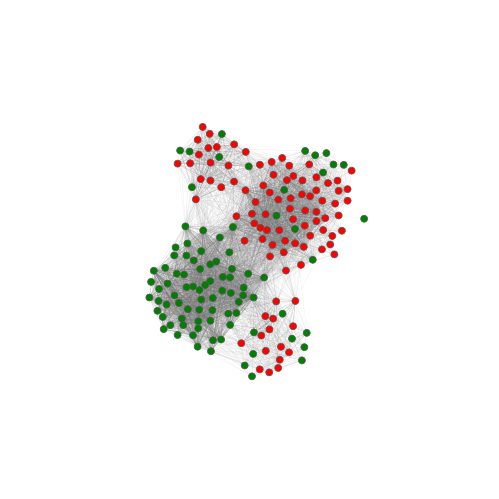

In [47]:
# ### UNCOMMENT TO GET GRAPH VISUALIZATION ! ### 

# # Create ground truth partition
# colors = ['green', 'red']
# fakenews_partition = [{node for node in G.nodes() if target in node} for target in ['Real', 'Fake']]

# # Retrieve color codes on the node level
# viz_partition = {}
# for i, partition_ in enumerate(tqdm(fakenews_partition)):
#     for node_ in partition_:
#         viz_partition[node_] = colors[i]

# # Set color codes on the node level
# nx.set_node_attributes(G, viz_partition, "group")

# # Visualize network
# stylized_network, config = nw.visualize(G)
# fig, ax = nw.draw_netwulf(stylized_network)
# plt.show()

In [126]:
# Other statistics (node-wise)
clustering_coefficient  = nx.clustering(G)
degree_centrality       = nx.degree_centrality(G)
betweenness_centrality  = nx.betweenness_centrality(G)
closeness_centrality    = nx.closeness_centrality(G)
eigenvector_centrality  = nx.eigenvector_centrality(G)

### Clustering - Louvain method

In [127]:
# Apply Louvain method for detecting best partition of the graph
louvain_partition       = nx.community.louvain_communities(G)
modularity              = nx.community.modularity(G, louvain_partition)
print(modularity)

0.5468606050851721


In [14]:
# ### UNCOMMENT TO GET GRAPH VISUALIZATION ! ###

# colors = [f"C{i}" for i in range(louvain_partition.__len__())]

# # Retrieve color codes on the node level
# viz_partition = {}
# for i, partition_ in enumerate(tqdm(louvain_partition)):
#     for node_ in partition_:
#         viz_partition[node_] = colors[i]

# # Set color codes on the node level
# nx.set_node_attributes(G, viz_partition, "group")

# # Visualize network
# stylized_network, config = nw.visualize(G)
# fig, ax = nw.draw_netwulf(stylized_network)
# plt.show()

In [17]:
from sklearn.metrics import balanced_accuracy_score

In [128]:
class KMeans_clustering:
    def __init__(self, n_clusters=2, random_state=42, max_iter=100, tol=1e-4):
        """
        Initialize the KMeans clustering model.

        Parameters:
        n_clusters (int): The number of clusters to form.
        random_state (int): Determines random number generation for centroid initialization.
        max_iter (int): Maximum number of iterations of the k-means algorithm for a single run.
        tol (float): Relative tolerance with regards to inertia to declare convergence.
        """
        self.train_centroids = None
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
    
    def fit_predict(self, X):
        """
        Compute k-means clustering and predict the cluster label for each sample.

        Parameters:
        X (array-like): List of n_features-dimensional data points. Each row corresponds to a single data point.

        Returns:
        cluster_labels (list of int): Predicted cluster labels for each sample.
        """
        # Create a random number generator with a specific seed
        rng = np.random.RandomState(self.random_state)

        # Initialize cluster centroids
        old_centroids = X[rng.choice(range(len(X)), size=self.n_clusters, replace=False)]
        centroids = old_centroids.copy()

        # Initialize cluster labels
        cluster_labels = np.zeros(len(X))

        # Iterate until convergence or until max_iterations is reached
        for iteration in range(self.max_iter):

            # Compute the distance between each data point and each centroid
            distances = euclidean_distances(X, centroids)

            # Assign each data point to the closest centroid
            new_cluster_labels = np.argmin(distances, axis=1)

            # Update the centroids and reinitialize empty clusters
            for c in range(self.n_clusters):
                if len(X[new_cluster_labels == c]) > 0:
                    centroids[c] = X[new_cluster_labels == c].mean(axis=0)
                else:  # reinitialize empty cluster
                    centroids[c] = X[rng.choice(range(len(X)))]

            # Check for convergence
            if np.sum((centroids - old_centroids)**2) < self.tol:
                break

            # Update the membership matrix and old centroids
            old_centroids = centroids.copy()
            cluster_labels = new_cluster_labels

        self.train_centroids = centroids

        return cluster_labels
    
    def predict(self, X):
        """Predict cluster labels for new data points.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row corresponds to a single data point.
        
        Returns
        -------
        list of int
            Predicted cluster labels for each sample.
        
        """
        # Compute pairwise distances between data points and cluster centroids
        distances = np.array([np.sqrt(np.sum((X - centroid)**2, axis=1)) for centroid in self.train_centroids])
        
        # Assign cluster labels
        cluster_labels = np.argmin(distances, axis=0)
        
        return cluster_labels

def DBSCAN_own(**kwargs):
    # TODO: implement DBSCAN algorithm from bottom...
    # TODO: make sure the format of the output is similar to what is seen below in the EvaluationModule.clustering function
    raise NotImplementedError("TODO!")

def louvain(**kwargs):
    # albertkjoller: note - should be run on the graph and then train afterwards...
    # TODO: make sure the format of the output is similar to what is seen below in the EvaluationModule.clustering function
    raise NotImplementedError("TODO!")


class EvaluationModule:

    def __init__(
        self,
        featurizer: BuzzFeedFeaturizer,
        model: RandomForestClassifier,
        metrics: List[str] = ['SS', 'DBI', 'CHS', 'ARI', 'NMI', 'accuracy', 'balanced_accuracy', 'weighted_f1_scores', 'precision', 'recall'],
        seed: int = 42,
    ):
        # Define featurizer and model
        self.featurizer         = featurizer
        self.model              = model
        # Setup evaluation metrics
        self.metrics            = metrics
        # Set seed
        self.seed               = seed
        
        # Whether run was triggered once
        self.run_count                  = 0
        self.previously_run_approaches  = []

        # Prepare prediction storage
        self.predictions        = defaultdict(dict)
        self.true_labels        = defaultdict(dict)
        self.feature_repr       = defaultdict(dict)

    def clustering(self, Xtrain, ytrain, Xtest, ytest, mode: str, **kwargs):
        
        info = {}
        if mode in ['KMeans', 'SpectralClustering']:
            # Define clustering model
            cls             = KMeans_clustering(n_clusters=kwargs['K_clusters'], random_state=self.seed, max_iter=100)
            
            # Get cluster labels
            train_clusters  = cls.fit_predict(Xtrain)
            test_clusters   = cls.predict(Xtest)
            # Get unique clusters
            info['unique_clusters'] = range(kwargs['K_clusters'])

        elif mode == 'DBSCAN':
            cls             = DBSCAN(eps=kwargs['eps'], min_samples=kwargs['min_samples'], metric = kwargs['metric'])

            # Run DBSCAN on the entire dataset
            X_total         = np.vstack((Xtrain, Xtest))
            db_total        = cls.fit(X_total)
            # Get cluster labels
            train_clusters  = db_total.labels_[:Xtrain.shape[0]]
            test_clusters   = db_total.labels_[Xtrain.shape[0]:]
            # Get unique clusters
            info['unique_clusters'] = np.unique(db_total.labels_)
            
        elif mode == 'HierarchicalClustering':
            raise NotImplementedError("TODO!")
        
        else:
            raise NotImplementedError('Specified clustering method not implemented!')

        return {k: [Xtrain[train_clusters == k], ytrain[train_clusters == k], Xtest[test_clusters == k], ytest[test_clusters == k]] for k in info['unique_clusters']}, info

    def fit_predict(self, feature_mode: str, modeling_approaches: List[str] = ['baseline', 'global'], **kwargs):
        """
        Fit models and get predictions according to modeling_approaches input.

        Args:
            feature_mode (str): Which feature mode to use, e.g. 'tf-idf' or 'node2vec'.
            modeling_approaches (List[str], optional): The approaches to run. Defaults to ['baseline', 'global'].
        """

        if self.run_count == 0:
            self.module_feature_mode        = feature_mode
        else:
            assert feature_mode == self.module_feature_mode, "Can only run one feature mode per initialized EvaluationModule object..."

        # Run cross-validation
        info = defaultdict(dict)
        for fold in tqdm(range(self.featurizer.K), desc='RUNNING CROSS-VALIDATION...'):
            Xtrain, ytrain, Xtest, ytest, feature_info = self.featurizer.get_feature_split(feature_mode=feature_mode, fold=fold, K_clusters=kwargs['K_clusters'])

            # Loop through experiments
            for modeling_approach in np.setdiff1d(modeling_approaches, self.previously_run_approaches):
                if modeling_approach == 'baseline': 
                    # Define majority voting baseline
                    uniques, counts                     = np.unique(ytrain, return_counts=True)
                    majority_voter                      = uniques[np.argmax(counts)]
                    # Get predictions
                    self.predictions['baseline'][fold]  = majority_voter * np.ones(ytest.shape)
                    # Store true labels
                    self.true_labels['baseline'][fold]  = ytest
                    # Store true feature representations
                    self.feature_repr['baseline'][fold] = Xtest

                elif modeling_approach == 'global':
                    # Train model
                    self.model.fit(Xtrain, ytrain)
                    # Get predictions
                    self.predictions['global'][fold]    = self.model.predict(Xtest)
                    # Store true labels
                    self.true_labels['global'][fold]    = ytest
                    # Store true feature representations
                    self.feature_repr['global'][fold]   = Xtest

                else:
                    # Run clustering and get output
                    if modeling_approach == 'KMeans':
                        cluster_dict, info_ = self.clustering(Xtrain, ytrain, Xtest, ytest, mode=modeling_approach, K_clusters=kwargs['K_clusters'])
                    elif modeling_approach == 'SpectralClustering':
                        cluster_dict, info_ = self.clustering(Xtrain, ytrain, Xtest, ytest, mode=modeling_approach, K_clusters=kwargs['K_clusters'])
                    elif modeling_approach == 'DBSCAN':
                        cluster_dict, info_ = self.clustering(Xtrain, ytrain, Xtest, ytest, mode=modeling_approach, eps=kwargs['eps'], min_samples=kwargs['min_samples'], metric = kwargs['metric'])

                    # Store information about unique clusters
                    info[(modeling_approach, fold)]['unique_clusters'] = info_['unique_clusters']

                    # Exploit local patterns
                    for cluster_idx, (Xtrain_c, ytrain_c, Xtest_c, ytest_c) in cluster_dict.items():
                        # Train local model
                        
                        self.model.fit(Xtrain_c, ytrain_c)

                        # Check if test-cluster is non-empty
                        if Xtest_c.shape[0] > 0:
                            # Store true labels and feature representations
                            self.predictions[(modeling_approach, cluster_idx)][fold]    = self.model.predict(Xtest_c)
                            self.true_labels[(modeling_approach, cluster_idx)][fold]    = ytest_c
                            self.feature_repr[(modeling_approach, cluster_idx)][fold]   = Xtest_c

                        else:
                            print('(', modeling_approach, cluster_idx, f' - fold {fold} ) testset is empty!')
                            # Store true labels and feature representations
                            self.predictions[(modeling_approach, cluster_idx)][fold]    = np.array([])
                            self.true_labels[(modeling_approach, cluster_idx)][fold]    = np.array([])
                            self.feature_repr[(modeling_approach, cluster_idx)][fold]   = np.empty((0, Xtrain_c.shape[1]))

        # Update already run approaches
        self.previously_run_approaches  = np.union1d(modeling_approaches, self.previously_run_approaches)
        self.store_global_clustering_predictions(info=info)

    def store_global_clustering_predictions(self, **kwargs):

        # Add global KMeans labels to predictions
        for clustering_method in np.setdiff1d(self.previously_run_approaches, ['baseline', 'global']):
            for fold in range(self.featurizer.K):
                # We concatenate the predictions, true labels and feature representations for each cluster.
                self.feature_repr[clustering_method][fold]  = np.concatenate([self.feature_repr[(clustering_method, k)][fold] for k in kwargs['info'][(clustering_method, fold)]['unique_clusters']])
                self.true_labels[clustering_method][fold]   = np.concatenate([self.true_labels[(clustering_method, k)][fold]  for k in kwargs['info'][(clustering_method, fold)]['unique_clusters']])
                self.predictions[clustering_method][fold]   = np.concatenate([self.predictions[(clustering_method, k)][fold]  for k in kwargs['info'][(clustering_method, fold)]['unique_clusters']])
            
    def get_performance(self, keep=None, **kwargs):
        results = defaultdict(dict)
        for fold in range(self.featurizer.K):
            
            # Store results
            results_fold = {}
            attributes   = keep if keep is not None else self.predictions.keys()
            # Iterate through modeling approaches
            for modeling_approach in attributes:
                ypred = self.predictions[modeling_approach][fold]

                # Get test set
                Xtest = self.feature_repr[modeling_approach][fold]
                ytest = self.true_labels[modeling_approach][fold]

                # Make sure that ytest and ypred are of the same 1D shape
                ypred = ypred.ravel()

                # Compute and store results
                results_fold[modeling_approach] = {}
                results_fold[modeling_approach]['SS']                = silhouette_score(Xtest, ypred) if np.unique(ypred).__len__() > 1 and len(ypred) > 2 else None
                results_fold[modeling_approach]['DBI']               = davies_bouldin_score(Xtest, ypred) if np.unique(ypred).__len__() > 1 and len(ypred) > 2 else None
                results_fold[modeling_approach]['CHS']               = calinski_harabasz_score(Xtest, ypred) if np.unique(ypred).__len__() > 1 and len(ypred) > 2 else None
                results_fold[modeling_approach]['ARI']               = adjusted_rand_score(ytest, ypred)
                results_fold[modeling_approach]['NMI']               = normalized_mutual_info_score(ytest, ypred)
                results_fold[modeling_approach]['accuracy']          = np.mean(ytest == ypred)
                results_fold[modeling_approach]['balanced_accuracy'] = balanced_accuracy_score(ytest, ypred)
                results_fold[modeling_approach]['weighted_f1_score'] = f1_score(ytest, ypred, average='weighted')
                results_fold[modeling_approach]['precision']         = precision_score(ytest, ypred, average='weighted', zero_division=0.0)
                results_fold[modeling_approach]['recall']            = recall_score(ytest, ypred, average='weighted', zero_division=1.0)

            results[fold] = pd.DataFrame(results_fold)

        return results
        
    def latex_results(self, results):
        
        # Compute mean and sem across folds
        results_    = np.stack([results[fold].to_numpy() for fold in range(self.featurizer.K)])
        mean_       = np.nanmean(results_, axis = 0)# .replace(np.inf, np.nan)
        sems_       = np.nanstd(np.stack([results[fold].to_numpy() for fold in range(self.featurizer.K)]), axis=0) / np.sqrt(self.featurizer.K)

        # Reformat as strings for proper latex display
        latex = np.ones(mean_.shape).astype(str)
        for i in range(mean_.shape[0]):
            for j in range(mean_.shape[1]):
                latex[i, j] = f"{mean_[i,j]:.3f} \pm {sems_[i,j]:.3f}"
        
        # Create dataframe
        df_latex    = pd.DataFrame(latex, columns=results[0].columns, index=results[0].index)
        mean_       = pd.DataFrame(mean_, columns=results[0].columns, index=results[0].index)
        sems_       = pd.DataFrame(sems_, columns=results[0].columns, index=results[0].index)

        return df_latex, mean_, sems_

In [61]:
featurizer  = BuzzFeedFeaturizer(datapath=DATA_DIR / f'processed/FakeNewsNet', K=5)
evaluator   = EvaluationModule(
    featurizer=featurizer, 
    model=RandomForestClassifier(n_estimators=100, random_state=42),
)

# Run and predict
K_clusters = 3
evaluator.fit_predict(feature_mode='tf-idf_pca', modeling_approaches=['baseline', 'global', 'KMeans', 'DBSCAN'], eps=1.32, min_samples=5, metric = 'euclidean', K_clusters=K_clusters)

100%|██████████| 146/146 [00:01<00:00, 143.09it/s][00:13<00:19,  6.51s/it]


( KMeans 2  - fold 2 ) testset is empty!


100%|██████████| 146/146 [00:01<00:00, 140.25it/s][00:25<00:06,  6.40s/it]


( KMeans 2  - fold 4 ) testset is empty!


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:31<00:00,  6.35s/it]


In [62]:
res_CV = evaluator.get_performance()

# Print latex results
res, mean, sem = evaluator.latex_results(res_CV)
print(res.to_latex())
res

d:\ProgramData\Anaconda3\envs\Computational_Tools_For_Data_Science_project\lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\ProgramData\Anaconda3\envs\Computational_Tools_For_Data_Science_project\lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\ProgramData\Anaconda3\envs\Computational_Tools_For_Data_Science_project\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\ProgramData\Anaconda3\envs\Computational_Tools_For_Data_Science_project\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\ProgramData\Anaconda3\envs\Computational_Tools_For_Data_Science_project\lib\site-pa

\begin{tabular}{lllllllll}
\toprule
 & ('DBSCAN', 0) & ('KMeans', 0) & ('KMeans', 1) & ('KMeans', 2) & baseline & global & DBSCAN & KMeans \\
\midrule
SS & 0.085 \pm 0.021 & 0.190 \pm 0.057 & 0.026 \pm 0.056 & 0.236 \pm 0.062 & nan \pm nan & 0.085 \pm 0.021 & 0.085 \pm 0.021 & 0.108 \pm 0.043 \\
DBI & 3.294 \pm 0.115 & 2.206 \pm 0.215 & 1.126 \pm 0.179 & 1.853 \pm 0.693 & nan \pm nan & 3.294 \pm 0.115 & 3.294 \pm 0.115 & 3.353 \pm 0.191 \\
CHS & 2.329 \pm 0.137 & 2.981 \pm 0.698 & 1.368 \pm 0.328 & 3.395 \pm 0.769 & nan \pm nan & 2.329 \pm 0.137 & 2.329 \pm 0.137 & 2.275 \pm 0.218 \\
ARI & 0.039 \pm 0.031 & 0.031 \pm 0.019 & 0.221 \pm 0.175 & 0.331 \pm 0.250 & 0.000 \pm 0.000 & 0.039 \pm 0.031 & 0.039 \pm 0.031 & 0.043 \pm 0.020 \\
NMI & 0.077 \pm 0.022 & 0.092 \pm 0.043 & 0.239 \pm 0.173 & 0.434 \pm 0.208 & 0.000 \pm 0.000 & 0.077 \pm 0.022 & 0.077 \pm 0.022 & 0.095 \pm 0.034 \\
accuracy & 0.589 \pm 0.040 & 0.554 \pm 0.054 & 0.516 \pm 0.120 & 0.572 \pm 0.074 & 0.467 \pm 0.014 & 0.589 

C:\Users\alex\AppData\Local\Temp\ipykernel_20952\1074208474.py:285: RuntimeWarning: Mean of empty slice
  mean_       = np.nanmean(results_, axis = 0)# .replace(np.inf, np.nan)
d:\ProgramData\Anaconda3\envs\Computational_Tools_For_Data_Science_project\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,"(DBSCAN, 0)","(KMeans, 0)","(KMeans, 1)","(KMeans, 2)",baseline,global,DBSCAN,KMeans
SS,0.085 \pm 0.021,0.190 \pm 0.057,0.026 \pm 0.056,0.236 \pm 0.062,nan \pm nan,0.085 \pm 0.021,0.085 \pm 0.021,0.108 \pm 0.043
DBI,3.294 \pm 0.115,2.206 \pm 0.215,1.126 \pm 0.179,1.853 \pm 0.693,nan \pm nan,3.294 \pm 0.115,3.294 \pm 0.115,3.353 \pm 0.191
CHS,2.329 \pm 0.137,2.981 \pm 0.698,1.368 \pm 0.328,3.395 \pm 0.769,nan \pm nan,2.329 \pm 0.137,2.329 \pm 0.137,2.275 \pm 0.218
ARI,0.039 \pm 0.031,0.031 \pm 0.019,0.221 \pm 0.175,0.331 \pm 0.250,0.000 \pm 0.000,0.039 \pm 0.031,0.039 \pm 0.031,0.043 \pm 0.020
NMI,0.077 \pm 0.022,0.092 \pm 0.043,0.239 \pm 0.173,0.434 \pm 0.208,0.000 \pm 0.000,0.077 \pm 0.022,0.077 \pm 0.022,0.095 \pm 0.034
accuracy,0.589 \pm 0.040,0.554 \pm 0.054,0.516 \pm 0.120,0.572 \pm 0.074,0.467 \pm 0.014,0.589 \pm 0.040,0.589 \pm 0.040,0.589 \pm 0.042
balanced_accuracy,0.606 \pm 0.040,0.575 \pm 0.034,0.458 \pm 0.107,0.531 \pm 0.045,0.500 \pm 0.000,0.606 \pm 0.040,0.606 \pm 0.040,0.602 \pm 0.045
weighted_f1_score,0.572 \pm 0.039,0.485 \pm 0.075,0.474 \pm 0.125,0.540 \pm 0.057,0.298 \pm 0.015,0.572 \pm 0.039,0.572 \pm 0.039,0.569 \pm 0.042
precision,0.646 \pm 0.046,0.573 \pm 0.108,0.515 \pm 0.161,0.632 \pm 0.075,0.219 \pm 0.013,0.646 \pm 0.046,0.646 \pm 0.046,0.645 \pm 0.058
recall,0.589 \pm 0.040,0.554 \pm 0.054,0.516 \pm 0.120,0.572 \pm 0.074,0.467 \pm 0.014,0.589 \pm 0.040,0.589 \pm 0.040,0.589 \pm 0.042


### Running text results

In [63]:
featurizer  = BuzzFeedFeaturizer(datapath=DATA_DIR / f'processed/FakeNewsNet', K=5)
evaluator   = EvaluationModule(
    featurizer=featurizer, 
    model=RandomForestClassifier(n_estimators=100, random_state=42),
)

# Run and predict
K_clusters = 2
evaluator.fit_predict(feature_mode='tf-idf', modeling_approaches=['baseline', 'global', 'KMeans', 'DBSCAN'], eps=0.3, min_samples=3, metric = 'euclidean', K_clusters=K_clusters)

RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:30<00:00,  6.03s/it]


In [64]:
spectral_featurizer  = BuzzFeedFeaturizer(datapath=DATA_DIR / f'processed/FakeNewsNet', K=5)
spectral_evaluator   = EvaluationModule(
    featurizer=spectral_featurizer, 
    model=RandomForestClassifier(n_estimators=100, random_state=42),
)

# Run and predict
K_clusters = 20
spectral_evaluator.fit_predict(feature_mode='spectral_text', modeling_approaches=['baseline', 'global', 'SpectralClustering'], K_clusters=K_clusters)

100%|██████████| 146/146 [00:00<00:00, 155.75it/s][00:00<?, ?it/s]


( SpectralClustering 6  - fold 0 ) testset is empty!
( SpectralClustering 10  - fold 0 ) testset is empty!
( SpectralClustering 14  - fold 0 ) testset is empty!
( SpectralClustering 15  - fold 0 ) testset is empty!
( SpectralClustering 16  - fold 0 ) testset is empty!


100%|██████████| 146/146 [00:01<00:00, 144.81it/s][00:07<00:30,  7.56s/it]


( SpectralClustering 16  - fold 1 ) testset is empty!


100%|██████████| 146/146 [00:00<00:00, 150.74it/s][00:15<00:22,  7.66s/it]


( SpectralClustering 2  - fold 2 ) testset is empty!
( SpectralClustering 4  - fold 2 ) testset is empty!
( SpectralClustering 5  - fold 2 ) testset is empty!
( SpectralClustering 7  - fold 2 ) testset is empty!
( SpectralClustering 18  - fold 2 ) testset is empty!


100%|██████████| 146/146 [00:00<00:00, 150.43it/s][00:22<00:15,  7.60s/it]


( SpectralClustering 1  - fold 3 ) testset is empty!
( SpectralClustering 7  - fold 3 ) testset is empty!
( SpectralClustering 12  - fold 3 ) testset is empty!
( SpectralClustering 14  - fold 3 ) testset is empty!


100%|██████████| 146/146 [00:00<00:00, 163.49it/s][00:29<00:07,  7.39s/it]


( SpectralClustering 2  - fold 4 ) testset is empty!
( SpectralClustering 17  - fold 4 ) testset is empty!


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:37<00:00,  7.41s/it]


In [65]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    # Extract results from cross-validation
    res_CV          = evaluator.get_performance(keep=['baseline', 'global', 'KMeans', 'DBSCAN'], folds=[0, 1, 2, 3, 4])
    spectral_res_CV = spectral_evaluator.get_performance(keep=['SpectralClustering'], folds=[0, 1, 2, 3, 4])
    
    res_CV = {k: pd.concat([res_CV[k], spectral_res_CV[k]], axis=1) for k in res_CV.keys()}

    # Get latex results
    res, mean, sem = evaluator.latex_results(res_CV)

# Print results
print(res.to_latex())
res

\begin{tabular}{llllll}
\toprule
 & baseline & global & KMeans & DBSCAN & SpectralClustering \\
\midrule
SS & nan \pm nan & 0.002 \pm 0.001 & 0.002 \pm 0.001 & 0.002 \pm 0.001 & 0.031 \pm 0.006 \\
DBI & nan \pm nan & 5.427 \pm 0.106 & 5.466 \pm 0.074 & 5.427 \pm 0.106 & 4.108 \pm 0.250 \\
CHS & nan \pm nan & 1.105 \pm 0.035 & 1.104 \pm 0.028 & 1.105 \pm 0.035 & 2.010 \pm 0.212 \\
ARI & 0.000 \pm 0.000 & 0.249 \pm 0.052 & 0.150 \pm 0.053 & 0.249 \pm 0.052 & 0.042 \pm 0.031 \\
NMI & 0.000 \pm 0.000 & 0.236 \pm 0.047 & 0.141 \pm 0.041 & 0.236 \pm 0.047 & 0.054 \pm 0.025 \\
accuracy & 0.467 \pm 0.014 & 0.750 \pm 0.031 & 0.694 \pm 0.033 & 0.750 \pm 0.031 & 0.606 \pm 0.035 \\
balanced_accuracy & 0.500 \pm 0.000 & 0.755 \pm 0.033 & 0.701 \pm 0.033 & 0.755 \pm 0.033 & 0.608 \pm 0.036 \\
weighted_f1_score & 0.298 \pm 0.015 & 0.748 \pm 0.032 & 0.692 \pm 0.035 & 0.748 \pm 0.032 & 0.602 \pm 0.037 \\
precision & 0.219 \pm 0.013 & 0.769 \pm 0.035 & 0.709 \pm 0.032 & 0.769 \pm 0.035 & 0.612 \pm 0.038

,baseline,global,KMeans,DBSCAN,SpectralClustering
SS,nan \pm nan,0.002 \pm 0.001,0.002 \pm 0.001,0.002 \pm 0.001,0.031 \pm 0.006
DBI,nan \pm nan,5.427 \pm 0.106,5.466 \pm 0.074,5.427 \pm 0.106,4.108 \pm 0.250
CHS,nan \pm nan,1.105 \pm 0.035,1.104 \pm 0.028,1.105 \pm 0.035,2.010 \pm 0.212
ARI,0.000 \pm 0.000,0.249 \pm 0.052,0.150 \pm 0.053,0.249 \pm 0.052,0.042 \pm 0.031
NMI,0.000 \pm 0.000,0.236 \pm 0.047,0.141 \pm 0.041,0.236 \pm 0.047,0.054 \pm 0.025
accuracy,0.467 \pm 0.014,0.750 \pm 0.031,0.694 \pm 0.033,0.750 \pm 0.031,0.606 \pm 0.035
balanced_accuracy,0.500 \pm 0.000,0.755 \pm 0.033,0.701 \pm 0.033,0.755 \pm 0.033,0.608 \pm 0.036
weighted_f1_score,0.298 \pm 0.015,0.748 \pm 0.032,0.692 \pm 0.035,0.748 \pm 0.032,0.602 \pm 0.037
precision,0.219 \pm 0.013,0.769 \pm 0.035,0.709 \pm 0.032,0.769 \pm 0.035,0.612 \pm 0.038
recall,0.467 \pm 0.014,0.750 \pm 0.031,0.694 \pm 0.033,0.750 \pm 0.031,0.606 \pm 0.035


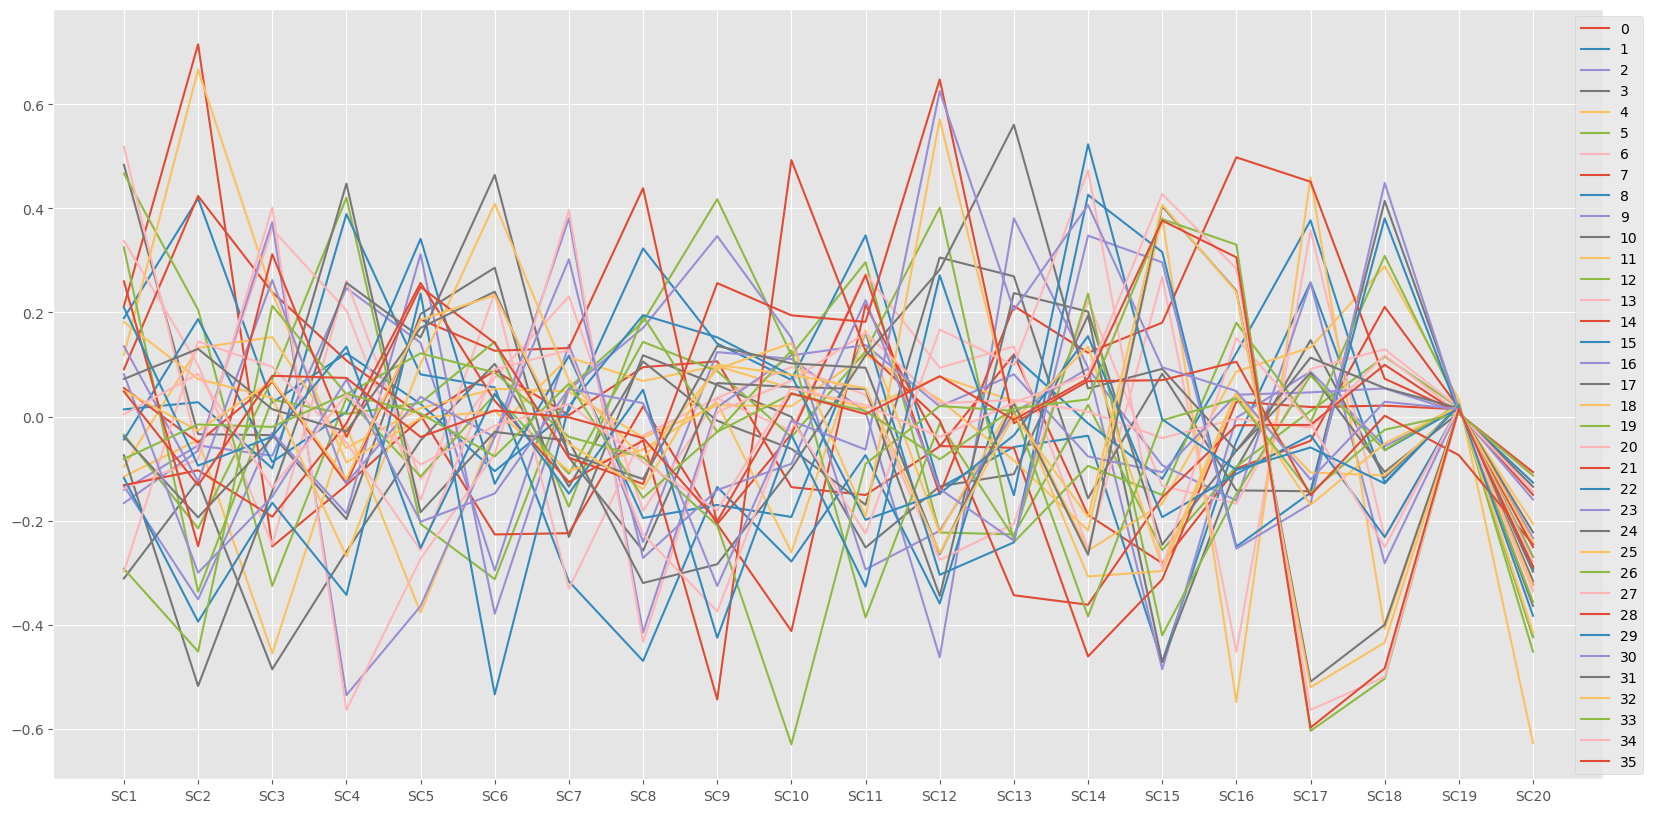

In [67]:
# Sort documents by closest resemblance to doc 0
index, similarity = list(zip(*sorted(zip(
    np.arange(spectral_evaluator.feature_repr['SpectralClustering'][0].shape[0]), 
    spectral_evaluator.feature_repr['SpectralClustering'][0].dot(spectral_evaluator.feature_repr['SpectralClustering'][0][0].reshape(-1,1))
    ), key=lambda x: x[1],
)))

index = np.array(index)
similarity = np.array(similarity)

sca = pd.DataFrame(spectral_evaluator.feature_repr['SpectralClustering'][0][index, :], columns=[f'SC{i+1}' for i in range(K_clusters)])
sca.T.plot(figsize=(20, 10))
plt.legend(loc='upper right', bbox_to_anchor=(1.03, 1.0))
plt.xticks(np.arange(K_clusters), labels=sca.columns)
plt.show()

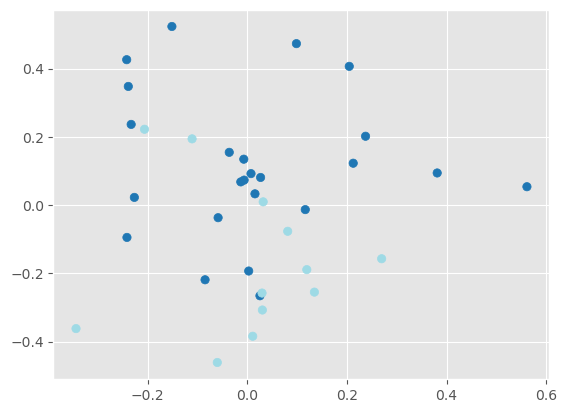

In [68]:
i = 6
plt.scatter(spectral_evaluator.feature_repr['SpectralClustering'][0][:, i*2], spectral_evaluator.feature_repr['SpectralClustering'][0][:, (i*2)+1], c=spectral_evaluator.predictions['SpectralClustering'][0], cmap='tab20')

### Running graph feature results

In [69]:
featurizer  = BuzzFeedFeaturizer(datapath=DATA_DIR / f'processed/FakeNewsNet', K=5)
evaluator   = EvaluationModule(
    featurizer=featurizer, 
    model=RandomForestClassifier(n_estimators=100, random_state=42),
)

# Run and predict
K_clusters = 2
evaluator.fit_predict(feature_mode='node2vec', modeling_approaches=['baseline', 'global', 'KMeans', 'DBSCAN'], eps=0.3, min_samples=3, metric = 'euclidean', K_clusters=K_clusters)

RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:31<00:00,  6.29s/it]


In [70]:
spectral_featurizer  = BuzzFeedFeaturizer(datapath=DATA_DIR / f'processed/FakeNewsNet', K=5)
spectral_evaluator   = EvaluationModule(
    featurizer=spectral_featurizer, 
    model=RandomForestClassifier(n_estimators=100, random_state=42),
)

# Run and predict
K_clusters = 20
spectral_evaluator.fit_predict(feature_mode='spectral_graph', modeling_approaches=['baseline', 'global', 'SpectralClustering'], K_clusters=K_clusters)

RUNNING CROSS-VALIDATION...:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\alex\AppData\Local\Temp\ipykernel_20952\1391968976.py:72: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A       = np.array(nx.adjacency_matrix(A).todense())


( SpectralClustering 1  - fold 0 ) testset is empty!
( SpectralClustering 5  - fold 0 ) testset is empty!
( SpectralClustering 15  - fold 0 ) testset is empty!
( SpectralClustering 18  - fold 0 ) testset is empty!


RUNNING CROSS-VALIDATION...:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]C:\Users\alex\AppData\Local\Temp\ipykernel_20952\1391968976.py:72: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A       = np.array(nx.adjacency_matrix(A).todense())


( SpectralClustering 0  - fold 1 ) testset is empty!
( SpectralClustering 4  - fold 1 ) testset is empty!
( SpectralClustering 5  - fold 1 ) testset is empty!
( SpectralClustering 7  - fold 1 ) testset is empty!
( SpectralClustering 8  - fold 1 ) testset is empty!
( SpectralClustering 14  - fold 1 ) testset is empty!
( SpectralClustering 16  - fold 1 ) testset is empty!


RUNNING CROSS-VALIDATION...:  40%|████      | 2/5 [00:05<00:08,  2.75s/it]

( SpectralClustering 19  - fold 1 ) testset is empty!


C:\Users\alex\AppData\Local\Temp\ipykernel_20952\1391968976.py:72: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A       = np.array(nx.adjacency_matrix(A).todense())


( SpectralClustering 0  - fold 2 ) testset is empty!
( SpectralClustering 2  - fold 2 ) testset is empty!
( SpectralClustering 3  - fold 2 ) testset is empty!
( SpectralClustering 5  - fold 2 ) testset is empty!
( SpectralClustering 8  - fold 2 ) testset is empty!
( SpectralClustering 10  - fold 2 ) testset is empty!


RUNNING CROSS-VALIDATION...:  60%|██████    | 3/5 [00:08<00:05,  2.69s/it]C:\Users\alex\AppData\Local\Temp\ipykernel_20952\1391968976.py:72: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A       = np.array(nx.adjacency_matrix(A).todense())


( SpectralClustering 6  - fold 3 ) testset is empty!
( SpectralClustering 7  - fold 3 ) testset is empty!
( SpectralClustering 15  - fold 3 ) testset is empty!
( SpectralClustering 17  - fold 3 ) testset is empty!


RUNNING CROSS-VALIDATION...:  80%|████████  | 4/5 [00:10<00:02,  2.68s/it]C:\Users\alex\AppData\Local\Temp\ipykernel_20952\1391968976.py:72: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A       = np.array(nx.adjacency_matrix(A).todense())


( SpectralClustering 5  - fold 4 ) testset is empty!
( SpectralClustering 9  - fold 4 ) testset is empty!
( SpectralClustering 16  - fold 4 ) testset is empty!


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


In [71]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    # Extract results from cross-validation
    res_CV          = evaluator.get_performance(keep=['baseline', 'global', 'KMeans', 'DBSCAN'], folds=[0, 1, 2, 3, 4])
    spectral_res_CV = spectral_evaluator.get_performance(keep=['SpectralClustering'], folds=[0, 1, 2, 3, 4])
    
    res_CV = {k: pd.concat([res_CV[k], spectral_res_CV[k]], axis=1) for k in res_CV.keys()}

    # Get latex results
    res, mean, sem = evaluator.latex_results(res_CV)

# Print results
print(res.to_latex())
res

\begin{tabular}{llllll}
\toprule
 & baseline & global & KMeans & DBSCAN & SpectralClustering \\
\midrule
SS & nan \pm nan & 0.211 \pm 0.019 & 0.210 \pm 0.021 & 0.211 \pm 0.019 & 0.088 \pm 0.011 \\
DBI & nan \pm nan & 1.797 \pm 0.145 & 1.812 \pm 0.150 & 1.797 \pm 0.145 & 3.102 \pm 0.216 \\
CHS & nan \pm nan & 9.596 \pm 1.166 & 9.517 \pm 1.263 & 9.596 \pm 1.166 & 3.510 \pm 0.345 \\
ARI & 0.000 \pm 0.000 & 0.428 \pm 0.073 & 0.379 \pm 0.057 & 0.428 \pm 0.073 & 0.400 \pm 0.133 \\
NMI & 0.000 \pm 0.000 & 0.384 \pm 0.066 & 0.342 \pm 0.055 & 0.384 \pm 0.066 & 0.368 \pm 0.119 \\
accuracy & 0.467 \pm 0.014 & 0.828 \pm 0.027 & 0.811 \pm 0.021 & 0.828 \pm 0.027 & 0.794 \pm 0.059 \\
balanced_accuracy & 0.500 \pm 0.000 & 0.830 \pm 0.026 & 0.814 \pm 0.022 & 0.830 \pm 0.026 & 0.795 \pm 0.059 \\
weighted_f1_score & 0.298 \pm 0.015 & 0.827 \pm 0.026 & 0.810 \pm 0.021 & 0.827 \pm 0.026 & 0.794 \pm 0.059 \\
precision & 0.219 \pm 0.013 & 0.838 \pm 0.028 & 0.823 \pm 0.024 & 0.838 \pm 0.028 & 0.802 \pm 0.060

,baseline,global,KMeans,DBSCAN,SpectralClustering
SS,nan \pm nan,0.211 \pm 0.019,0.210 \pm 0.021,0.211 \pm 0.019,0.088 \pm 0.011
DBI,nan \pm nan,1.797 \pm 0.145,1.812 \pm 0.150,1.797 \pm 0.145,3.102 \pm 0.216
CHS,nan \pm nan,9.596 \pm 1.166,9.517 \pm 1.263,9.596 \pm 1.166,3.510 \pm 0.345
ARI,0.000 \pm 0.000,0.428 \pm 0.073,0.379 \pm 0.057,0.428 \pm 0.073,0.400 \pm 0.133
NMI,0.000 \pm 0.000,0.384 \pm 0.066,0.342 \pm 0.055,0.384 \pm 0.066,0.368 \pm 0.119
accuracy,0.467 \pm 0.014,0.828 \pm 0.027,0.811 \pm 0.021,0.828 \pm 0.027,0.794 \pm 0.059
balanced_accuracy,0.500 \pm 0.000,0.830 \pm 0.026,0.814 \pm 0.022,0.830 \pm 0.026,0.795 \pm 0.059
weighted_f1_score,0.298 \pm 0.015,0.827 \pm 0.026,0.810 \pm 0.021,0.827 \pm 0.026,0.794 \pm 0.059
precision,0.219 \pm 0.013,0.838 \pm 0.028,0.823 \pm 0.024,0.838 \pm 0.028,0.802 \pm 0.060
recall,0.467 \pm 0.014,0.828 \pm 0.027,0.811 \pm 0.021,0.828 \pm 0.027,0.794 \pm 0.059


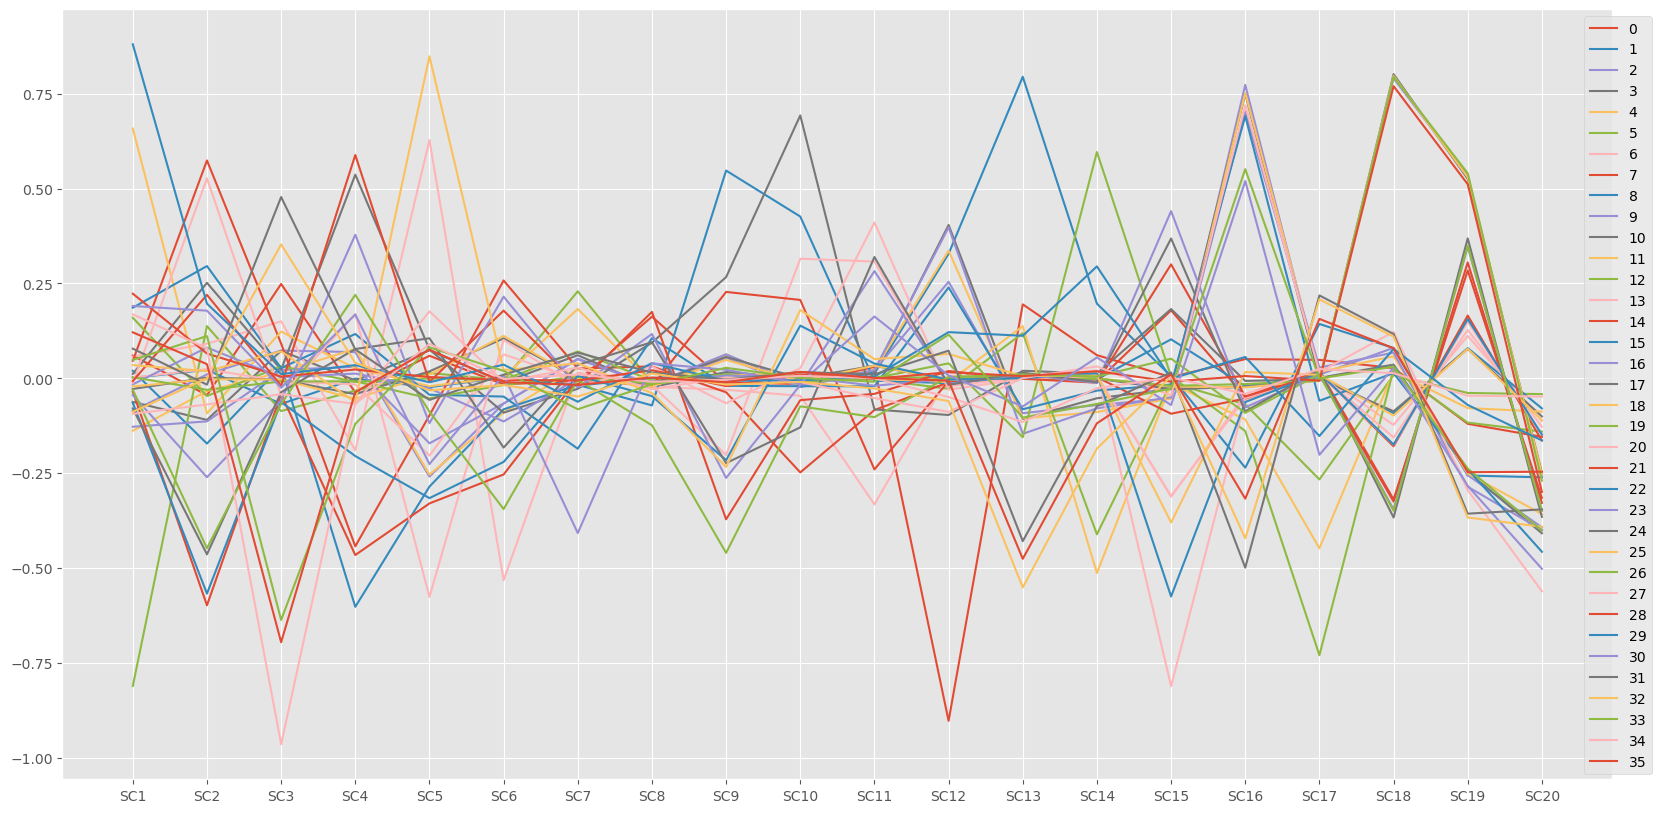

In [72]:
# Sort documents by closest resemblance to doc 0
index, similarity = list(zip(*sorted(zip(
    np.arange(spectral_evaluator.feature_repr['SpectralClustering'][0].shape[0]), 
    spectral_evaluator.feature_repr['SpectralClustering'][0].dot(spectral_evaluator.feature_repr['SpectralClustering'][0][0].reshape(-1,1))
    ), key=lambda x: x[1],
)))

index = np.array(index)
similarity = np.array(similarity)

sca = pd.DataFrame(spectral_evaluator.feature_repr['SpectralClustering'][0][index, :], columns=[f'SC{i+1}' for i in range(K_clusters)])
sca.T.plot(figsize=(20, 10))
plt.legend(loc='upper right', bbox_to_anchor=(1.03, 1.0))
plt.xticks(np.arange(K_clusters), labels=sca.columns)
plt.show()

## Below is code to remove a fraction of a NX graph object

In [129]:
import random
from sklearn.decomposition import PCA

def rm_rand_edge(graph, fraction=0.1, n=9):
    '''
    Remove a random edge in the nx graph object up to a fraction of the original graph's edges.
    
    Standard input is removing 10% at a time up to 90% of the original graph.
    '''
    nr_edges = graph.edges().__len__()
    removers = int(np.floor(fraction*nr_edges))

    c = [graph]
    
    for j in range(n):
        # Copy last graph in c
        copied_graph = c[-1].copy()
        for i in range(0, removers):
            # Remove random edges
            edges = list(copied_graph.edges)
            edge_choice = random.choice(edges)
            copied_graph.remove_edge(edge_choice[0], edge_choice[1])
        # Save new graph
        c.append(copied_graph)
    
    return c

# Verify connectivity
def graph_attributes(graph):
    print(f"Is the graph fully connected: {nx.is_connected(graph)}\n")

    # Degree distribution
    return print(str(graph)+'\n'+50*'=')

def plot_node2vec_pca(g, ax, total_edges):
    np.random.seed(0)
    
    # Get node2vec embeddings
    node2vec    = Node2Vec(g, dimensions=32, walk_length=10, num_walks=100)
    model       = node2vec.fit(window=10, min_count=1)

    # Get vector representations
    train2vec       = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key)}
    Xtrain          = np.array(list(train2vec.values()))
    ytrain          = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key]) 

    # Run PCA projection
    pca             = PCA(n_components=2, random_state=42)
    pca_proj        = pca.fit_transform(Xtrain)

    for label in ['fake', 'real']:
        ax.scatter(pca_proj[ytrain == label, 0], pca_proj[ytrain == label, 1], label=label, color='red' if label == 'fake' else 'green')
    ax.set_title(f'{g.edges.__len__() / total_edges:.2f}% edges', fontsize=16)
    ax.legend(loc='upper right')


In [130]:
graph_attributes(G)

q = rm_rand_edge(G, fraction=0.1, n=9)
print(f"There are {len(q)} Graph objects in the list.")

Is the graph fully connected: True

Graph with 182 nodes and 4772 edges
There are 10 Graph objects in the list.


In [131]:
for i, g in enumerate(q):
    # Get the edge attributes
    edge_attributes = nx.get_edge_attributes(g, 'weight')
    
    pct = (10 - i) * 10
    
    # Extract the sources, targets, and weights
    sources = [edge[0] for edge in edge_attributes.keys()]
    targets = [edge[1] for edge in edge_attributes.keys()]
    weights = list(edge_attributes.values())

    # Create the DataFrame
    df = pd.DataFrame({'source': sources, 'target': targets, 'weight': weights})
    df.to_csv(f"../data/processed/FakeNewsNet/BuzzFeed_graph_{pct}.csv", index=False)

 30%|███       | 3/10 [01:05<02:27, 21.11s/it]

( KMeans 3  - fold 1 ) testset is empty!


 60%|██████    | 6/10 [01:56<01:11, 17.93s/it]

( KMeans 0  - fold 4 ) testset is empty!


 90%|█████████ | 9/10 [02:45<00:16, 16.87s/it]

( KMeans 0  - fold 4 ) testset is empty!


100%|██████████| 10/10 [03:01<00:00, 18.16s/it]


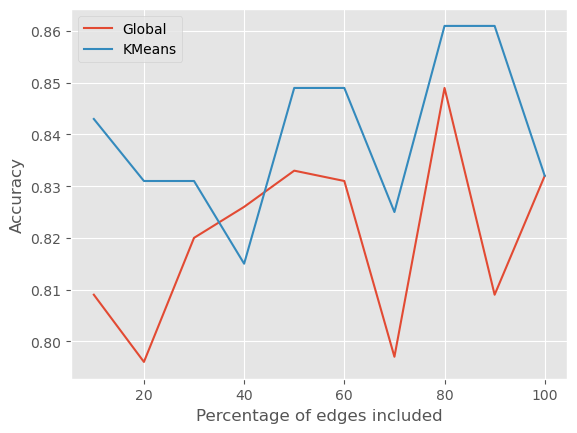

In [132]:
global_accs = []
KMeans_accs = []

for pct in tqdm(range(10, 110, 10)):
    featurizer  = BuzzFeedFeaturizer(datapath=DATA_DIR / f'processed/FakeNewsNet', K=5, graph_size_pct=pct)
    evaluator   = EvaluationModule(
        featurizer=spectral_featurizer, 
        model=RandomForestClassifier(n_estimators=100, random_state=42),
    )

    # Run and predict
    K_clusters = 4
    evaluator.fit_predict(feature_mode='node2vec', modeling_approaches=['baseline', 'global', 'KMeans'], K_clusters=K_clusters)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Extract results from cross-validation
        res_CV          = evaluator.get_performance(keep=['global', 'KMeans'], folds=[0, 1, 2, 3, 4])

        # Get latex results
        res, mean, sem = evaluator.latex_results(res_CV)
    
    global_accs.append(float(res["global"]["accuracy"].split(" ")[0]))
    KMeans_accs.append(float(res["KMeans"]["accuracy"].split(" ")[0]))

# Plot results
plt.plot(range(10, 110, 10), global_accs, label="Global")
plt.plot(range(10, 110, 10), KMeans_accs, label="KMeans")
plt.xlabel("Percentage of edges included")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Is the graph fully connected: True

Graph with 182 nodes and 4772 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 37.79it/s]


Is the graph fully connected: True

Graph with 182 nodes and 4295 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:03<00:00, 31.32it/s]


Is the graph fully connected: True

Graph with 182 nodes and 3818 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:05<00:00, 17.64it/s]


Is the graph fully connected: True

Graph with 182 nodes and 3341 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:03<00:00, 32.84it/s]


Is the graph fully connected: True

Graph with 182 nodes and 2864 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


Is the graph fully connected: False

Graph with 182 nodes and 2387 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:04<00:00, 22.16it/s]


Is the graph fully connected: False

Graph with 182 nodes and 1910 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


Is the graph fully connected: False

Graph with 182 nodes and 1433 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:03<00:00, 29.28it/s]


Is the graph fully connected: False

Graph with 182 nodes and 956 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 50.83it/s]


Is the graph fully connected: False

Graph with 182 nodes and 479 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 36.23it/s]


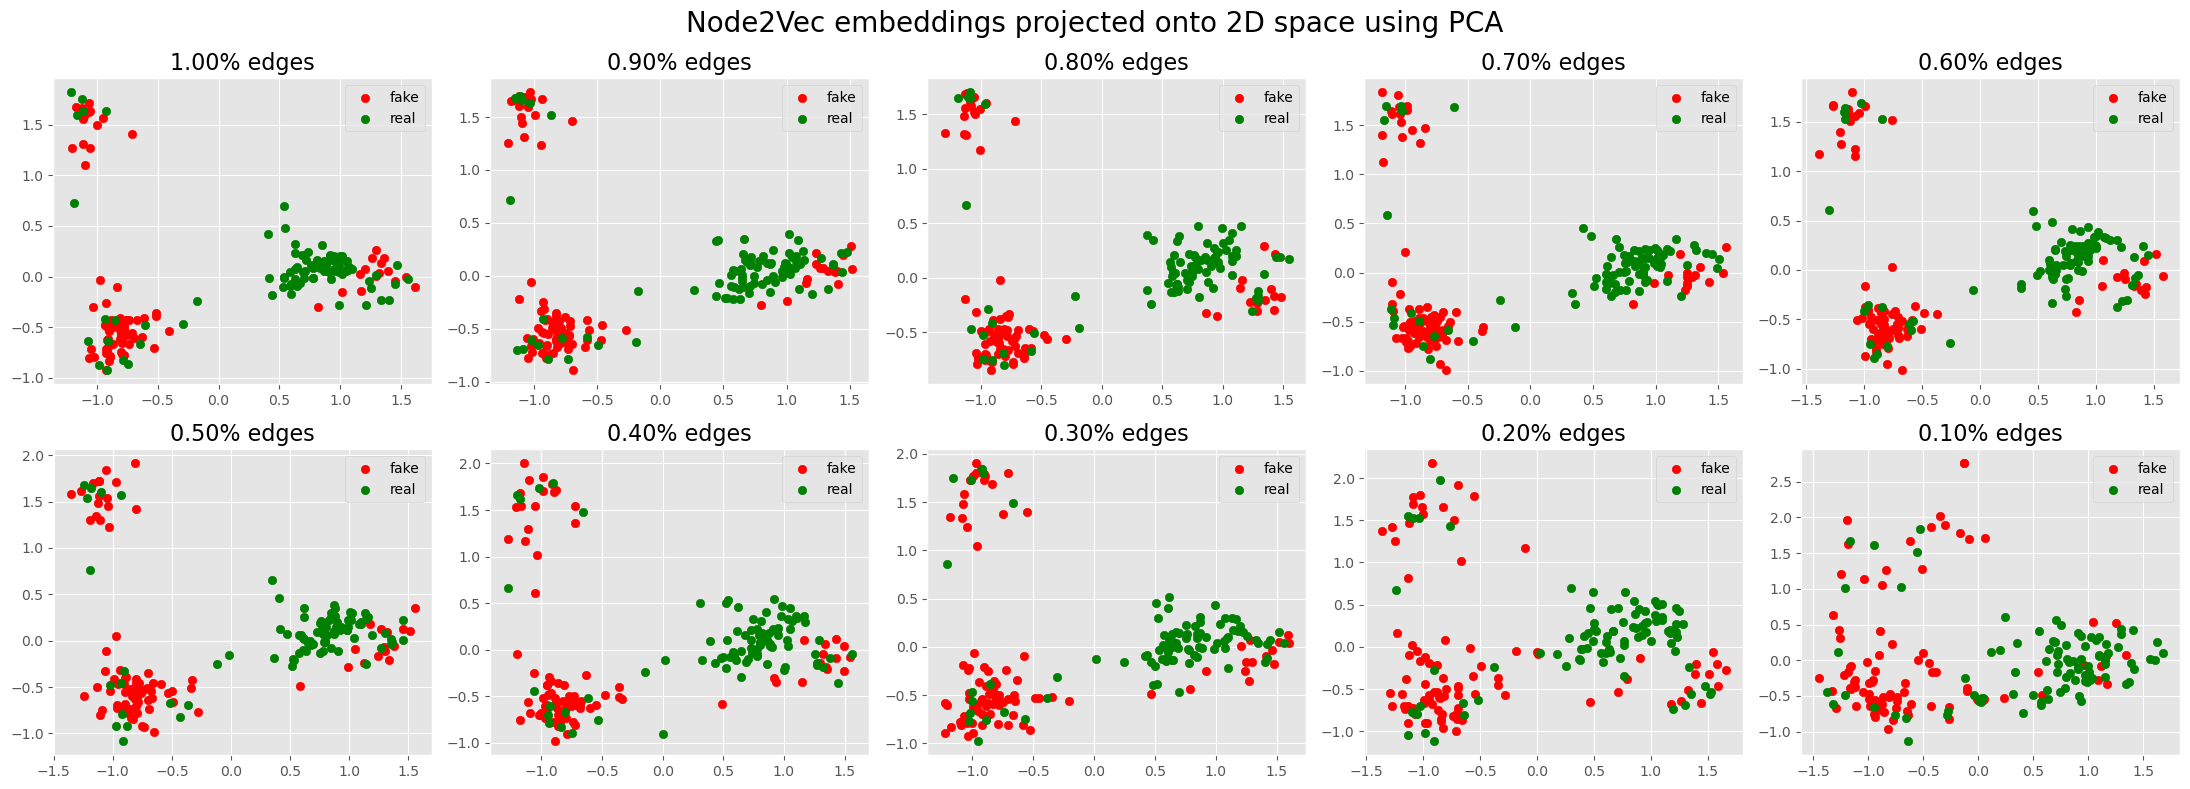

In [78]:
fig, axs = plt.subplots(2, 5, figsize=(22, 8))
for i, g in enumerate(q):
    # Return graph info
    graph_attributes(g)
    # Plot node2vec embeddings
    plot_node2vec_pca(g, axs[i // 5, i % 5], total_edges=G.edges.__len__())

fig.suptitle('Node2Vec embeddings projected onto 2D space using PCA', fontsize=20)
plt.tight_layout()
plt.show()